<a href="https://colab.research.google.com/github/sudheerresearchai-max/AI-Enhanced-Image-Dehazing-for-Advanced-Driver-Assistance-Systems-ADAS-/blob/main/AI_Dehazing_ADAS_v2_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


               AI-ENHANCED DEHAZING & ADAS SYSTEM (v2 - Fixed)

📸 Downloading foggy/smokey road test image...
Trying to download from: https://images.unsplash.com/photo-1541919329513-4f...
  Failed: HTTP Error 404: Not Found
Trying to download from: https://upload.wikimedia.org/wikipedia/commons/b/b...
  Failed: HTTP Error 404: Not Found
Trying to download from: https://images.pexels.com/photos/1118877/pexels-ph...
✓ Downloaded successfully!
✓ Test image ready: sample_foggy_road.jpg


--- 1. Dehazing sample_foggy_road.jpg ---
✓ Dehazing complete.

--- 2. Running AI Scene Perception ---
Loading AI Perception Model (YOLOv5)...


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


⚠ WARNING: Failed to load YOLOv5 model: No module named 'ultralytics'
Continuing with classical detection methods only.
⚠ YOLOv5 not available, returning empty object list.
✓ Detected 0 relevant objects.
✓ Lane detection complete. (L: 1, R: 5)

--- 3. Computing Autonomous Decision ---
✓ Decision computed.

--- 4. Generating Visualization ---

✓ Visualization saved to 'results.png'

AI-ENHANCED DEHAZING & ADAS DECISION

📊 VISIBILITY METRICS:
   Visibility Score: 7.921 (Combined score)
   Mean Transmission: 0.730 (How much haze was removed)
   Contrast Ratio: 0.808x
   Edge Ratio: 1.196x

🚗 AUTONOMOUS DECISION:
   Status: SAFE
   Risk Level: MINIMAL
   Recommended Speed: 65 km/h
   Action: ✅ NORMAL OPERATION
   Scene: Clear road



DEMONSTRATING AI MODEL TRAINING
This is a toy example to show how the RiskAssessmentNN would be trained.
Loaded dummy dataset with 6 samples.
Starting training for 100 epochs...
Epoch [20/100], Loss: 0.5026
Epoch [40/100], Loss: 0.3514
Epoch [60/100], Loss: 0.

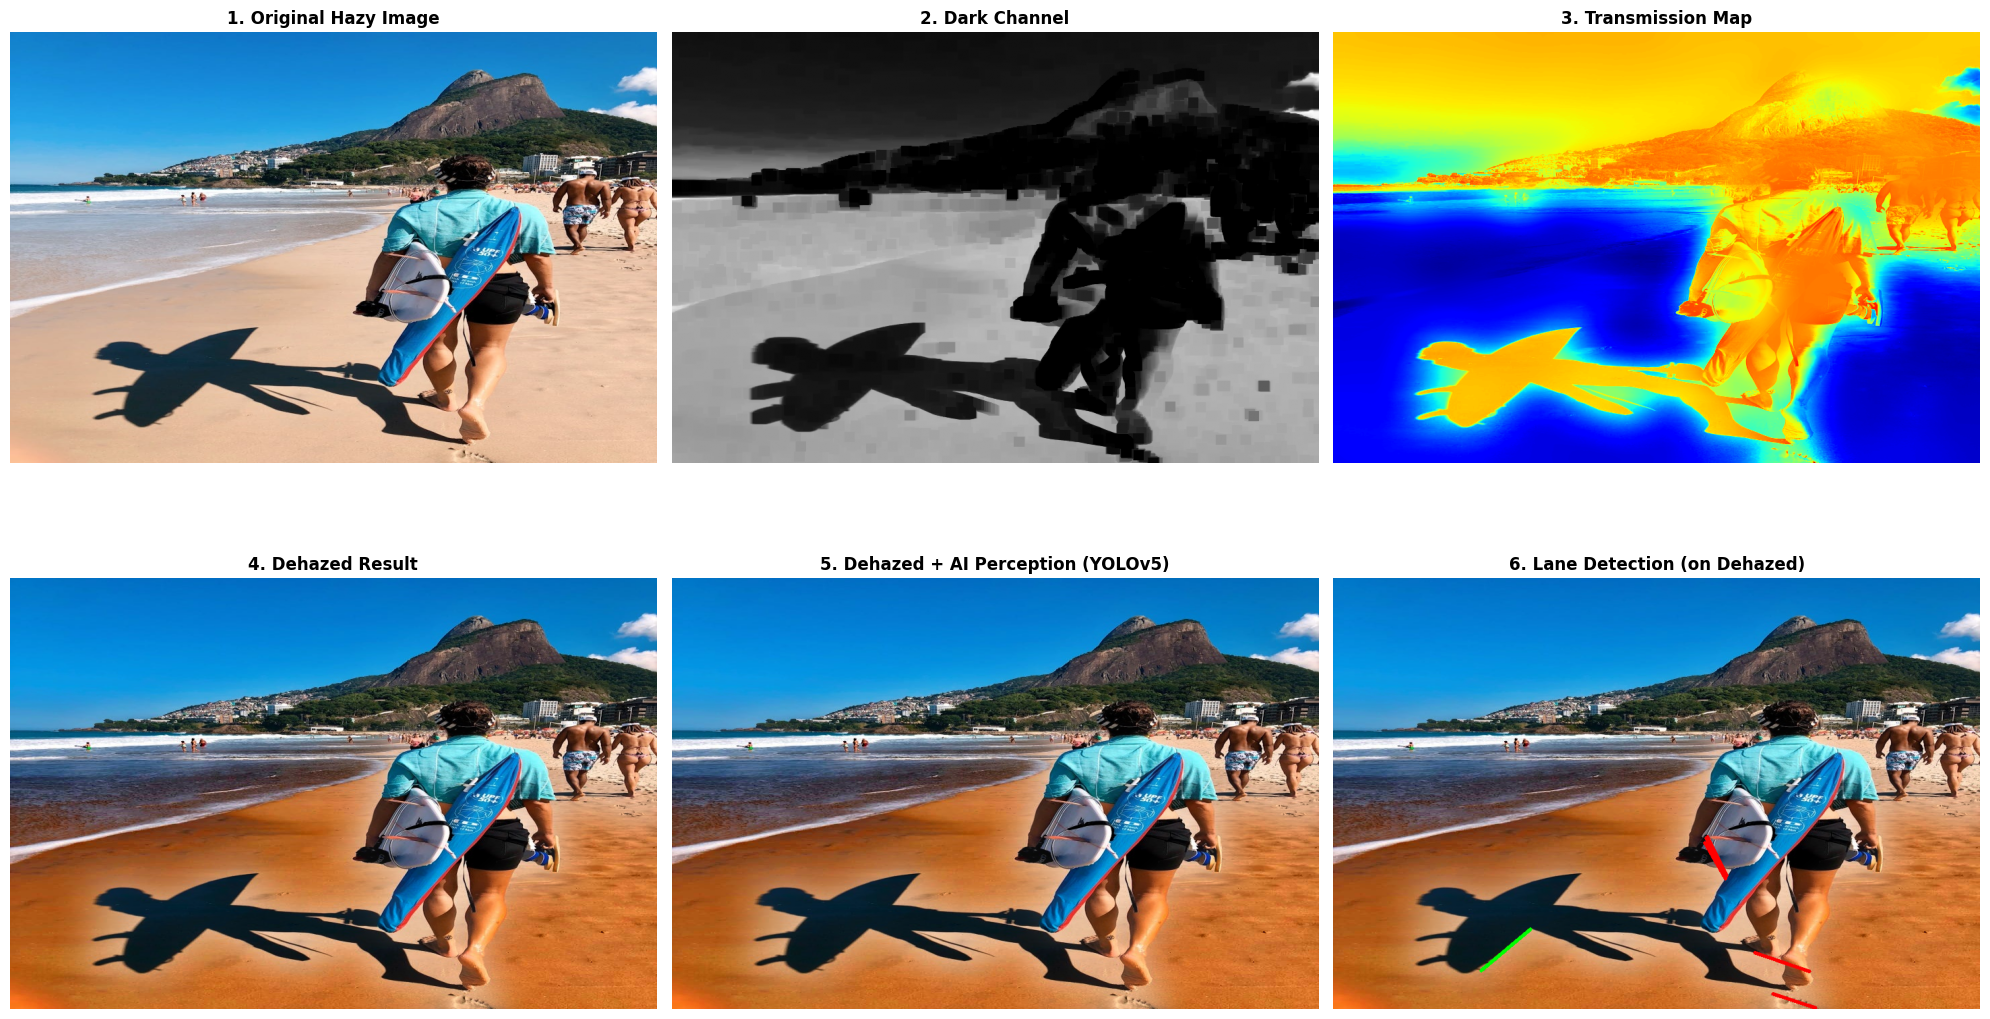

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import urllib.request
import os
from PIL import Image
import io

# Suppress warnings
warnings.filterwarnings('ignore')

class ImageDehazer:
    """
    Implements the Dark Channel Prior (DCP) algorithm for image dehazing.
    This is a classical (non-ML) computer vision technique.
    """
    def __init__(self, omega=0.95, t0=0.1, patch_size=15, guided_radius=60, guided_eps=0.001):
        self.omega = omega
        self.t0 = t0
        self.patch_size = patch_size
        self.guided_radius = guided_radius
        self.guided_eps = guided_eps

    def get_dark_channel(self, img, patch_size):
        """Calculates the dark channel of an image."""
        b, g, r = cv2.split(img)
        min_channel = cv2.min(cv2.min(r, g), b)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size, patch_size))
        return cv2.erode(min_channel, kernel)

    def estimate_atmospheric_light(self, img, dark_channel, top_percent=0.001):
        """Estimates the atmospheric light 'A'."""
        h, w = img.shape[:2]
        num_pixels = int(h * w * top_percent)
        dark_vec = dark_channel.reshape(h * w)
        img_vec = img.reshape(h * w, 3)
        indices = dark_vec.argsort()[-num_pixels:]

        brightest_index_in_top = np.argmax(np.linalg.norm(img_vec[indices], axis=1))
        brightest_pixel_index = indices[brightest_index_in_top]

        return img_vec[brightest_pixel_index]

    def estimate_transmission(self, img, atmospheric_light):
        """Estimates the transmission map 't(x)'."""
        normalized = img.astype(np.float64) / atmospheric_light
        return 1 - self.omega * self.get_dark_channel(normalized, self.patch_size)

    def guided_filter(self, guide, input_img, radius, epsilon):
        """Performs Guided Filtering to refine the transmission map."""
        mean_I = cv2.boxFilter(guide, cv2.CV_64F, (radius, radius))
        mean_p = cv2.boxFilter(input_img, cv2.CV_64F, (radius, radius))
        mean_Ip = cv2.boxFilter(guide * input_img, cv2.CV_64F, (radius, radius))
        cov_Ip = mean_Ip - mean_I * mean_p
        mean_II = cv2.boxFilter(guide * guide, cv2.CV_64F, (radius, radius))
        var_I = mean_II - mean_I * mean_I
        a = cov_Ip / (var_I + epsilon)
        b = mean_p - a * mean_I
        mean_a = cv2.boxFilter(a, cv2.CV_64F, (radius, radius))
        mean_b = cv2.boxFilter(b, cv2.CV_64F, (radius, radius))
        return mean_a * guide + mean_b

    def recover_scene_radiance(self, img, transmission, atmospheric_light):
        """Recovers the scene radiance 'J(x)' using the dehazing formula."""
        transmission = np.maximum(transmission, self.t0)
        recovered = np.zeros_like(img, dtype=np.float64)
        for channel in range(3):
            recovered[:, :, channel] = (img[:, :, channel] - atmospheric_light[channel]) / transmission + atmospheric_light[channel]
        return np.clip(recovered * 255, 0, 255).astype(np.uint8)

    def dehaze(self, img):
        """Main function to run the complete dehazing pipeline."""
        img_normalized = img.astype(np.float64) / 255.0
        dark_channel = self.get_dark_channel(img_normalized, self.patch_size)
        atmospheric_light = self.estimate_atmospheric_light(img_normalized, dark_channel)

        atmospheric_light = np.maximum(atmospheric_light, 0.01)

        transmission = self.estimate_transmission(img_normalized, atmospheric_light)

        gray = cv2.cvtColor((img_normalized * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        gray_normalized = gray.astype(np.float64) / 255.0

        refined_transmission = self.guided_filter(gray_normalized, transmission, self.guided_radius, self.guided_eps)
        dehazed = self.recover_scene_radiance(img_normalized, refined_transmission, atmospheric_light)

        metrics = self.calculate_visibility_metrics(img, dehazed, refined_transmission)
        return dehazed, metrics, refined_transmission, dark_channel

    def calculate_visibility_metrics(self, original, dehazed, transmission):
        """Calculates quantitative metrics to evaluate dehazing quality."""
        orig_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
        dehz_gray = cv2.cvtColor(dehazed, cv2.COLOR_BGR2GRAY)

        contrast_enhancement = (np.std(dehz_gray) + 1e-6) / (np.std(orig_gray) + 1e-6)

        edges_orig = cv2.Canny(orig_gray, 50, 150)
        edges_dehz = cv2.Canny(dehz_gray, 50, 150)

        edge_ratio = (np.sum(edges_dehz > 0) + 1e-6) / (np.sum(edges_orig > 0) + 1e-6)

        mean_transmission = np.mean(transmission)

        visibility_score = (contrast_enhancement * 2.0 + edge_ratio * 1.0 + mean_transmission * 7.0)

        if mean_transmission < 0.2:
            visibility_score = 0.0

        return {
            'visibility_score': visibility_score,
            'contrast_enhancement': contrast_enhancement,
            'edge_enhancement': edge_ratio,
            'mean_transmission': mean_transmission,
        }


class ScenePerception:
    """Uses YOLOv5 for object detection with robust error handling."""
    def __init__(self):
        print("Loading AI Perception Model (YOLOv5)...")
        self.model = None
        try:
            # Try to load YOLOv5
            self.model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True, trust_repo=True)
            self.model.conf = 0.35
            self.model.iou = 0.45
            print("✓ YOLOv5 model loaded successfully.")
        except Exception as e:
            print(f"⚠ WARNING: Failed to load YOLOv5 model: {e}")
            print("Continuing with classical detection methods only.")

    def _get_distance_label(self, ymax, img_height):
        """Simple proxy for distance based on vertical position."""
        if ymax > img_height * 0.8:
            return "Very Close"
        if ymax > img_height * 0.6:
            return "Close"
        if ymax > img_height * 0.4:
            return "Medium"
        return "Far"

    def detect_objects(self, img_rgb):
        """Detects objects in an RGB image using YOLOv5."""
        if self.model is None:
            print("⚠ YOLOv5 not available, returning empty object list.")
            return []

        try:
            h, w = img_rgb.shape[:2]
            results = self.model(img_rgb)

            df = results.pandas().xyxy[0]
            objects = []

            for _, row in df.iterrows():
                obj_type = row['name']

                if obj_type in ['person', 'bicycle', 'car', 'motorcycle', 'bus', 'truck', 'traffic light', 'stop sign']:
                    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
                    distance = self._get_distance_label(ymax, h)

                    objects.append({
                        'type': obj_type,
                        'distance': distance,
                        'bbox': (xmin, ymin, xmax - xmin, ymax - ymin),
                        'confidence': row['confidence'],
                        'ymax': ymax
                    })

            objects.sort(key=lambda o: o['ymax'], reverse=True)
            return objects
        except Exception as e:
            print(f"⚠ Object detection error: {e}")
            return []

    def detect_lanes(self, img):
        """Detects lane lines using Canny edge detection and Hough transform."""
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray, (5, 5), 0)
            edges = cv2.Canny(blur, 50, 150)
            h, w = img.shape[:2]

            mask = np.zeros_like(edges)
            polygon = np.array([
                [(0, h), (w, h), (int(w * 0.6), int(h * 0.6)), (int(w * 0.4), int(h * 0.6))]
            ], np.int32)
            cv2.fillPoly(mask, polygon, 255)
            masked_edges = cv2.bitwise_and(edges, mask)

            lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=20)

            lane_img = img.copy()
            left_lines, right_lines = [], []
            lanes_detected = False

            if lines is not None:
                lanes_detected = True
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    if abs(x2 - x1) < 1e-3:
                        continue

                    slope = (y2 - y1) / (x2 - x1)

                    if abs(slope) < 0.3:
                        continue

                    if slope < 0 and x1 < w / 2:
                        left_lines.append(line)
                        cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                    elif slope > 0 and x1 > w / 2:
                        right_lines.append(line)
                        cv2.line(lane_img, (x1, y1), (x2, y2), (0, 0, 255), 3)

            return lanes_detected, lane_img, {'left_count': len(left_lines), 'right_count': len(right_lines)}
        except Exception as e:
            print(f"⚠ Lane detection error: {e}")
            return False, img.copy(), {'left_count': 0, 'right_count': 0}


class DecisionLogic:
    """Implements the Autonomous Decision System."""
    def autonomous_decision_system(self, visibility_metrics, objects, lanes_detected):
        vis_score = visibility_metrics['visibility_score']

        if vis_score == 0 or visibility_metrics['mean_transmission'] < 0.2:
            speed, action, status, risk_level = 0, "🛑 EMERGENCY STOP", "CRITICAL", "EXTREME"
        elif vis_score < 3.0:
            speed, action, status, risk_level = 10, "🚨 CRAWL SPEED", "DANGER", "HIGH"
        elif vis_score < 5.0:
            speed, action, status, risk_level = 25, "⚠️ SEVERE CAUTION", "WARNING", "MEDIUM"
        elif vis_score < 7.0:
            speed, action, status, risk_level = 45, "⚡ MODERATE CAUTION", "MODERATE", "LOW"
        else:
            speed, action, status, risk_level = 65, "✅ NORMAL OPERATION", "SAFE", "MINIMAL"

        critical_objects = []
        close_vehicles = []

        for obj in objects:
            if obj['distance'] in ['Very Close', 'Close']:
                if obj['type'] in ['person', 'bicycle', 'stop sign']:
                    critical_objects.append(obj)
                elif obj['type'] in ['car', 'truck', 'bus', 'motorcycle']:
                    close_vehicles.append(obj)

        if critical_objects:
            obj_type = critical_objects[0]['type'].upper()
            speed, action, risk_level = 0, f"🛑 {obj_type} DETECTED - STOP", "EXTREME"
        elif close_vehicles:
            speed = min(speed, 15)
            action = f"🚗 {len(close_vehicles)} VEHICLE(S) AHEAD"
            risk_level = "HIGH" if risk_level != "EXTREME" else risk_level

        if not lanes_detected:
            speed = min(speed, 20)
            action += " - No Lanes"
            risk_level = "HIGH" if risk_level != "EXTREME" else risk_level

        detected = [f"{obj['type']} ({obj['distance']})" for obj in objects if obj['distance'] in ['Very Close', 'Close']]
        scene_description = ", ".join(detected[:3]) if detected else "Clear road"

        return {
            'status': status,
            'action': action,
            'speed_kmh': int(speed),
            'risk_level': risk_level,
            'scene': scene_description
        }


class RiskAssessmentNN(nn.Module):
    """Neural Network for risk assessment."""
    def __init__(self):
        super(RiskAssessmentNN, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))


def train_risk_model_example():
    """Demonstrates training the RiskAssessmentNN model."""
    print("\n" + "="*80)
    print("DEMONSTRATING AI MODEL TRAINING")
    print("="*80)
    print("This is a toy example to show how the RiskAssessmentNN would be trained.")

    X_train = torch.tensor([
        [1.0, 1, 0, 0],
        [2.0, 0, 2, 0],
        [5.0, 0, 1, 1],
        [9.0, 0, 0, 1],
        [7.0, 0, 0, 0],
        [8.0, 1, 0, 1],
    ], dtype=torch.float32)

    y_train = torch.tensor([
        [1.0], [0.9], [0.5], [0.1], [0.4], [1.0]
    ], dtype=torch.float32)

    print(f"Loaded dummy dataset with {len(X_train)} samples.")

    model = RiskAssessmentNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    num_epochs = 100
    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    print("✓ Training complete.")

    model.eval()
    with torch.no_grad():
        test_case = torch.tensor([[2.5, 1, 1, 0]], dtype=torch.float32)
        prediction = model(test_case)
        print(f"\nTest Case: [vis=2.5, obstacle=1, vehicle=1, lanes=0]")
        print(f"Predicted Risk (Trained Model): {prediction.item():.4f} (Expect ~0.9-1.0)")

        test_case_2 = torch.tensor([[9.5, 0, 0, 1]], dtype=torch.float32)
        prediction_2 = model(test_case_2)
        print(f"Test Case: [vis=9.5, obstacle=0, vehicle=0, lanes=1]")
        print(f"Predicted Risk (Trained Model): {prediction_2.item():.4f} (Expect ~0.1)")

    print("="*80 + "\n")
    return model


class Visualization:
    """Handles all plotting and terminal output."""

    def visualize_results(self, original, dehazed, transmission, dark_channel, metrics, decision, objects, lane_img):
        orig_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        dehz_rgb = cv2.cvtColor(dehazed, cv2.COLOR_BGR2RGB)
        lane_rgb = cv2.cvtColor(lane_img, cv2.COLOR_BGR2RGB)

        annotated = dehz_rgb.copy()
        for obj in objects:
            x, y, w, h = obj['bbox']

            if obj['type'] in ['person', 'bicycle', 'stop sign']:
                color = (255, 0, 0)
            elif obj['distance'] in ['Very Close', 'Close']:
                color = (255, 165, 0)
            else:
                color = (0, 255, 0)

            cv2.rectangle(annotated, (x, y), (x+w, y+h), color, 2)
            label = f"{obj['type']} ({obj['distance']})"
            cv2.putText(annotated, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        fig = plt.figure(figsize=(20, 12))

        plt.subplot(2, 3, 1)
        plt.imshow(orig_rgb)
        plt.title('1. Original Hazy Image', fontweight='bold')
        plt.axis('off')

        plt.subplot(2, 3, 2)
        plt.imshow(dark_channel, cmap='gray')
        plt.title('2. Dark Channel', fontweight='bold')
        plt.axis('off')

        plt.subplot(2, 3, 3)
        plt.imshow(transmission, cmap='jet')
        plt.title('3. Transmission Map', fontweight='bold')
        plt.axis('off')

        plt.subplot(2, 3, 4)
        plt.imshow(dehz_rgb)
        plt.title('4. Dehazed Result', fontweight='bold')
        plt.axis('off')

        plt.subplot(2, 3, 5)
        plt.imshow(annotated)
        plt.title('5. Dehazed + AI Perception (YOLOv5)', fontweight='bold')
        plt.axis('off')

        plt.subplot(2, 3, 6)
        plt.imshow(lane_rgb)
        plt.title('6. Lane Detection (on Dehazed)', fontweight='bold')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig('results.png', dpi=150, bbox_inches='tight')
        print(f"\n✓ Visualization saved to 'results.png'")

        print("\n" + "="*80)
        print("AI-ENHANCED DEHAZING & ADAS DECISION")
        print("="*80)
        print(f"\n📊 VISIBILITY METRICS:")
        print(f"   Visibility Score: {metrics['visibility_score']:.3f} (Combined score)")
        print(f"   Mean Transmission: {metrics['mean_transmission']:.3f} (How much haze was removed)")
        print(f"   Contrast Ratio: {metrics['contrast_enhancement']:.3f}x")
        print(f"   Edge Ratio: {metrics['edge_enhancement']:.3f}x")

        print(f"\n🚗 AUTONOMOUS DECISION:")
        print(f"   Status: {decision['status']}")
        print(f"   Risk Level: {decision['risk_level']}")
        print(f"   Recommended Speed: {decision['speed_kmh']} km/h")
        print(f"   Action: {decision['action']}")
        print(f"   Scene: {decision['scene']}")
        print("\n" + "="*80 + "\n")


def download_foggy_road_sample(filename="sample_foggy_road.jpg"):
    """Downloads a real foggy/smokey road image for testing."""
    # Try multiple sources
    urls = [
        "https://images.unsplash.com/photo-1541919329513-4f6e0fb62a63?w=960",  # Foggy road
        "https://upload.wikimedia.org/wikipedia/commons/b/ba/Foggy_road_in_S%C3%A3o_Paulo_state.jpg",
        "https://images.pexels.com/photos/1118877/pexels-photo-1118877.jpeg?auto=compress&cs=tinysrgb&w=960"
    ]

    for url in urls:
        try:
            print(f"Trying to download from: {url[:50]}...")
            req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})

            with urllib.request.urlopen(req, timeout=15) as response:
                img_data = response.read()
                img_array = np.frombuffer(img_data, np.uint8)
                img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

                if img is not None:
                    img = cv2.resize(img, (960, 640))
                    cv2.imwrite(filename, img)
                    print(f"✓ Downloaded successfully!")
                    return img, filename
        except Exception as e:
            print(f"  Failed: {e}")
            continue

    # Fallback: create synthetic foggy image
    print("All downloads failed. Creating synthetic foggy road image...")
    img = create_synthetic_foggy_road()
    cv2.imwrite(filename, img)
    return img, filename


def create_synthetic_foggy_road():
    """Creates a synthetic foggy road image for testing."""
    h, w = 640, 960
    img = np.zeros((h, w, 3), dtype=np.uint8)

    # Gray background (fog)
    img[:, :] = (180, 180, 180)

    # Draw road
    road_pts = np.array([
        [w//2 - 200, h],
        [w//2 - 80, h//2],
        [w//2 + 80, h//2],
        [w//2 + 200, h]
    ], np.int32)
    cv2.fillPoly(img, [road_pts], (80, 80, 80))

    # Draw lane lines
    for i in range(10):
        y_start = h - i * 60
        y_end = h - i * 60 - 30
        cv2.line(img, (w//2 - 10, y_start), (w//2 - 10, y_end), (200, 200, 200), 3)
        cv2.line(img, (w//2 + 10, y_start), (w//2 + 10, y_end), (200, 200, 200), 3)

    # Add fog overlay
    fog = np.ones_like(img, dtype=np.uint8) * 220
    img = cv2.addWeighted(img, 0.4, fog, 0.6, 0)

    # Add some "cars" as rectangles
    cv2.rectangle(img, (300, 400), (400, 500), (100, 50, 50), -1)
    cv2.rectangle(img, (560, 400), (660, 500), (100, 50, 50), -1)

    return img


def process_image(image_path):
    """Main processing pipeline: Dehaze -> Perceive -> Decide -> Visualize"""
    img = cv2.imread(image_path)
    if img is None:
        print(f"ERROR: Cannot read {image_path}")
        return

    print(f"\n--- 1. Dehazing {image_path} ---")
    dehazer = ImageDehazer()
    dehazed, metrics, transmission, dark_channel = dehazer.dehaze(img)
    cv2.imwrite('dehazed_output.jpg', dehazed)
    print("✓ Dehazing complete.")

    print("\n--- 2. Running AI Scene Perception ---")
    perception = ScenePerception()

    dehazed_rgb = cv2.cvtColor(dehazed, cv2.COLOR_BGR2RGB)
    objects = perception.detect_objects(dehazed_rgb)
    print(f"✓ Detected {len(objects)} relevant objects.")

    lanes_detected, lane_img, lane_info = perception.detect_lanes(dehazed)
    cv2.imwrite('lanes_output.jpg', lane_img)
    print(f"✓ Lane detection complete. (L: {lane_info['left_count']}, R: {lane_info['right_count']})")

    print("\n--- 3. Computing Autonomous Decision ---")
    logic = DecisionLogic()
    decision = logic.autonomous_decision_system(metrics, objects, lanes_detected)
    print("✓ Decision computed.")

    print("\n--- 4. Generating Visualization ---")
    visualizer = Visualization()
    visualizer.visualize_results(img, dehazed, transmission, dark_channel, metrics, decision, objects, lane_img)


if __name__ == "__main__":
    print("\n" + "="*80)
    print(" "*15 + "AI-ENHANCED DEHAZING & ADAS SYSTEM (v2 - Fixed)")
    print("="*80 + "\n")

    print("📸 Downloading foggy/smokey road test image...")
    foggy_img, sample_path = download_foggy_road_sample()
    print(f"✓ Test image ready: {sample_path}\n")

    # Run the main image processing pipeline
    process_image(sample_path)

    # Run the training demonstration
    trained_model = train_risk_model_example()

    print("\n✅ All processing complete!")
    print("Check the following output files:")
    print("  - results.png (main visualization)")
    print("  - dehazed_output.jpg")
    print("  - lanes_output.jpg")